In [5]:
from NeuralGraph import NeuralGraph
import torch
from torch import nn
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

C:\Users\Alec\AppData\Local\Temp\ipykernel_7540\770984268.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
device = "cpu"

### New set of equivalent eqns. that are implementable in ANNs

In [7]:
# Now that we have confirmed our functions work perfectly, we will hand implement them in ANNs bc I have no life :)

# To approx. f(x) = 1 if x > 0 else 0 we will use the following (for integers, will actually threshold at .5):
# s(ax-a/2) which for large a is essentially what we want
# To pass a value through a sigmoid we will use f(x) = 4*a*s(x/a)+2*a

# n[0] is activation
# n[1] is bias
# n[2] is dL/dz (pre activation grad)
# n[3] is haslbl
# n[4] is da/dz (sigmoid gradient = s(x)*(1-s(x)))
# n[5] is apply_b_grad?

# e[0] is weight
# e[1] is -lr * gradient
# e[2] is apply_w_grad?



# Output: 1 layer MLP
# Easy
# o[0] = n[0]

# Input
# Easy w/ 1 layer MLP
# i[0] = inp[0] - n[0]

# Label: 1 layer MultMLP
# Create another ch_n: n[4] which simply keeps track of (1 if n[0] > 0 else 0), than have this be a multiplication MLP
# l[2] = 2 * n[0] * n[4] - 2 * lbl[0] * n[4] - n[2] # Have distributed this now so multiplications happen first
# Easy
# l[3] = 1 - n[3]

# Message: 1 layer MultMLP
# Will have to be a mult net
# Easy for a mult net
# m_a[2] = e[0] * n_b[2]
# Easy
# m_a[3] = n_b[3]
# Easy for mult net
# m_b[0] = n_a[0] * e[0]
# Easy for mult net
# m_b[1] = n_b[3] - n_a[3] * n_b[3] # Have distributed again
# This has been broken into two steps: e[1] and e[2] will calculate -lr * n_a[0] * n_b[2] and n_b[3] - n_a[3] * n_b[3] respectively and then next iter they will be combined into e[0]
# m_e[0] = e[1] * e[2]
# m_e[1] = -lr * n_a[0] * n_b[2] - e[1]
# m_e[2] = n_b[3] - n_a[3] * n_b[3] - e[2]

# Update: 2 layer MultMLP
# Use new pass through function
# Has to pass through n[0]
# u[0] = s(agg_m_b[0] + n[1]) - n[0]
# Broke down into intermediate step in n[5], will have to pass through
# u[1] = -lr * n[2] * n[5]
# Will have to pass through
# u[2] = agg_m_a[2] * n[4] - n[2]
# Use approx. if
# u[3] = (1 if agg_m_a[3] > 0 else 0) - n[3]
# Will have to make sure multiplications include squaring here :|
# u[4] = s(x) - s(x)^2 - n[4]
# u[5] = (1 if agg_m_b[1] > 0 else 0) - n[5]

In [81]:
lr=.001
ch_n = 6
ch_e = 3

a = 1000.
def pass_thru(x):
    return a*nn.functional.tanh(x/a)
def tanhif(x):
    return nn.functional.tanh(a*x - a/2)/2 + .5

def desired_inp(x):
    i = torch.zeros(*x.shape[:-1], ch_n).to(device)
    i[..., 0] = x[..., 0] - x[..., 1]
    return i

def desired_out(x):
    return x[..., :1]

def desired_lbl(x):
    lbl, n = torch.tensor_split(x, [1], -1)
    l = torch.zeros(*x.shape[:-1], ch_n).to(device)

    # l[2] = n[0] * n[4] - lbl[0] * n[4] - n[2]
    # l[3] = 1 - n[3]

    l[..., 2] = 2 * n[..., 0] * n[..., 4] - 2 * lbl[..., 0] * n[..., 4] - n[..., 2]# (n[..., 0] - lbl[..., 0]) * torch.where(n[..., 0] <= 0, 0, 1) - n[..., 2]
    l[..., 3] = 1 - n[..., 3]
    return l

def desired_message(x):
    n_a, n_b, e = torch.tensor_split(x, [ch_n, ch_n*2], -1)
    m_a, m_b, m_e = torch.zeros(*x.shape[:-1], ch_n).to(device), torch.zeros(*x.shape[:-1], ch_n).to(device), torch.zeros(*x.shape[:-1], ch_e).to(device)

    # m_a[2] = e[0] * n_b[2]
    # m_a[3] = n_b[3]
    # m_b[0] = n_a[0] * e[0]
    # m_b[1] = n_b[3] - n_a[3] * n_b[3]
    # m_e[0] = e[1] * e[2]
    # m_e[1] = -lr * n_a[0] * n_b[2] - e[1]
    # m_e[2] = n_b[3] - n_a[3] * n_b[3] - e[2]

    m_a[..., 2] = e[..., 0] * n_b[..., 2]
    m_a[..., 3] = n_b[..., 3]
    m_b[..., 0] = n_a[..., 0] * e[..., 0]
    m_b[..., 1] = n_b[..., 3] - n_a[..., 3] * n_b[..., 3]
    m_e[..., 0] = e[..., 1] * e[..., 2]
    m_e[..., 1] = -lr * n_a[..., 0] * n_b[..., 2] - e[..., 1]
    m_e[..., 2] = n_b[..., 3] - n_a[..., 3] * n_b[..., 3] - e[..., 2]

    return torch.cat([m_a, m_b, m_e], axis=-1)

def desired_update(x):
    agg_m_a, agg_m_b, n = torch.tensor_split(x, [ch_n, ch_n*2], -1)
    u = torch.zeros(*x.shape[:-1], ch_n).to(device)

    # u[0] = ReLU(agg_m_b[0] + n[1]) - n[0]
    # u[1] = -lr * n[2] * n[5]
    # u[2] = agg_m_a[2] * n[4] - n[2]
    # u[3] = (1 if agg_m_a[3] > 0 else 0) - n[3]
    # u[4] = (1 if n[0] > 0 else 0) - n[4]
    # u[5] = (1 if agg_m_b[1] > 0 else 0) - n[5]

    # u[..., 0] = nn.functional.sigmoid(agg_m_b[..., 0] + n[..., 1]) - n[..., 0]
    # u[..., 1] = -lr * n[..., 2] * n[..., 5]
    # u[..., 2] = agg_m_a[..., 2] * n[..., 4] - n[..., 2]
    # u[..., 3] = torch.where(agg_m_a[..., 3] > .5, 1, 0) - n[..., 3]
    # u[..., 4] = n[..., 0] - n[..., 0]**2 - n[..., 4]
    # u[..., 5] = torch.where(agg_m_b[..., 1] > .5, 1, 0) - n[..., 5]
    
    # Seeing how much sigmoid approx. fck things up - 
    u[..., 0] = nn.functional.tanh(agg_m_b[..., 0] + n[..., 1]) + pass_thru(-n[..., 0])
    u[..., 1] = -lr * pass_thru(n[..., 2] * n[..., 5])
    u[..., 2] = pass_thru(agg_m_a[..., 2] * n[..., 4]) + pass_thru(-n[..., 2])
    u[..., 3] = tanhif(agg_m_a[..., 3]) + pass_thru(-n[..., 3])# torch.where(agg_m_a[..., 3] > .5, 1, 0) - n[..., 3]
    u[..., 4] = 1 - pass_thru(n[..., 0]**2) + pass_thru(-n[..., 4])
    u[..., 5] = tanhif(agg_m_b[..., 1]) + pass_thru(-n[..., 5])# torch.where(agg_m_b[..., 1] > .5, 1, 0) - n[..., 5]

    return u

In [82]:
class Hard_Func(nn.Module): # Wrap them as modules so torch doesn't get angry
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

In [83]:
size = 7

shape = [size**2, 16, 2]

connections = [(i, j) for k in range(len(shape)-1) for i in range(sum(shape[:k]), sum(shape[:k+1])) for j in range(sum(shape[:k+1]), sum(shape[:k+2]))]
print(len(connections))

graph = NeuralGraph(sum(shape), shape[0], shape[-1], connections, ch_n=ch_n, ch_e=ch_e, clamp_mode="none", value_init="zeros", aggregation="sum", use_label=True, device=device)

graph.inp_int = Hard_Func(desired_inp)# inp_enc.to(device)
graph.out_int = Hard_Func(desired_out)# out_enc.to(device)
graph.label_int = Hard_Func(desired_lbl)# label_enc.to(device)
graph.messages = nn.ModuleList([Hard_Func(desired_message)])# nn.ModuleList([message.to(device)])
graph.updates = nn.ModuleList([Hard_Func(desired_update)])# nn.ModuleList([update.to(device)])

816


In [84]:
class Test_MLP(nn.Module):
    def __init__(self, shape):
        super().__init__()

        modules = []
        for i in range(len(shape)-1):
            modules.append(nn.Linear(shape[i], shape[i+1]))
            modules.append(nn.Tanh())

        self.main = nn.Sequential(*modules)
    
    def forward(self, x):
        return self.main(x)

In [85]:
copycat = Test_MLP(shape).to(device)

In [86]:
# Copy copycat vals to graph
def init_vals(copycat, batch_size=1):
    edge_states = []
    bias_states = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_states.append(layer.weight.clone().T.reshape(-1))
        bias_states.append(layer.bias.clone())

    edge_states = torch.cat(edge_states, axis=0)
    bias_states = torch.cat([torch.zeros(shape[0]).to(device), *bias_states], axis=0)

    graph.init_vals(batch_size=batch_size)
    graph.edges[:, :, 0] = edge_states.clone().unsqueeze(0)
    graph.nodes[:, :, 1] = bias_states

def get_grads(copycat):
    edge_grads = []
    bias_grads = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_grads.append(layer.weight.grad.clone().T.reshape(-1))
        bias_grads.append(layer.bias.grad.clone())

    edge_grads = torch.cat(edge_grads, axis=0)
    bias_grads = torch.cat([torch.zeros(shape[0]).to(device), *bias_grads], axis=0)
    return edge_grads, bias_grads

In [87]:
init_vals(copycat)

dummy_inp = torch.randn(1, 49).to(device)
dummy_label = torch.randn(1, 2).to(device)

print(copycat(dummy_inp))
print(graph.forward(dummy_inp))

tensor([[0.0458, 0.1620]], grad_fn=<TanhBackward0>)
tensor([[0.0458, 0.1620]], grad_fn=<SqueezeBackward1>)


In [88]:
copycat.zero_grad()

out = copycat(dummy_inp)
loss = torch.square(dummy_label - out).sum(-1).mean()

loss.backward()

w_grad, b_grad = get_grads(copycat)

print(w_grad.shape, b_grad.shape)

torch.Size([816]) torch.Size([67])


In [89]:
init_vals(copycat)

old_w = graph.edges[..., 0].clone().flatten()
old_b = graph.nodes[..., 1].clone().flatten()
graph.forward(dummy_inp, edges=True)
graph.backward(dummy_inp, dummy_label, edges=True)

# The negative lr has already been mult. so divide out
delta_w = (graph.edges[..., 0].flatten() - old_w.flatten()) / -lr

delta_b = (graph.nodes[..., 1].flatten() - old_b.flatten()) / -lr

In [90]:
print(torch.abs(delta_w - w_grad).mean() / torch.abs(w_grad).mean())

tensor(6.4641e-06, grad_fn=<DivBackward0>)


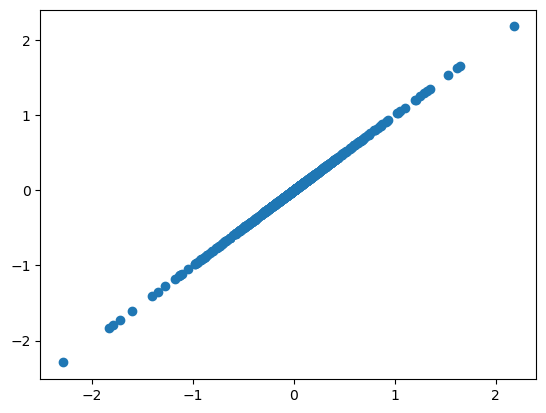

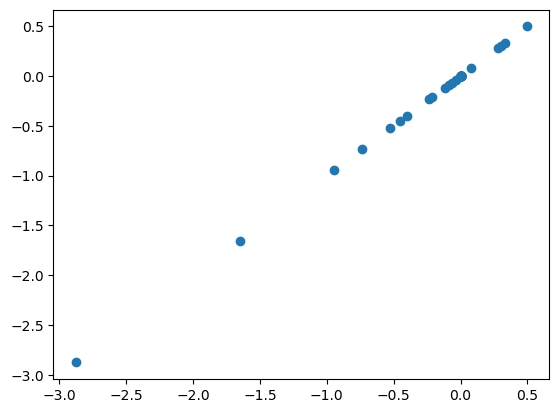

In [91]:
plt.scatter(delta_w.detach().cpu(), w_grad.detach().cpu())
plt.show()

plt.scatter(delta_b.detach().cpu(), b_grad.detach().cpu())
plt.show()

In [92]:
# Scratch work for figuring out indices
print({i+18:conn for i, conn in enumerate([(i, j) for i in range(18) for j in range(i, 18)])})

{18: (0, 0), 19: (0, 1), 20: (0, 2), 21: (0, 3), 22: (0, 4), 23: (0, 5), 24: (0, 6), 25: (0, 7), 26: (0, 8), 27: (0, 9), 28: (0, 10), 29: (0, 11), 30: (0, 12), 31: (0, 13), 32: (0, 14), 33: (0, 15), 34: (0, 16), 35: (0, 17), 36: (1, 1), 37: (1, 2), 38: (1, 3), 39: (1, 4), 40: (1, 5), 41: (1, 6), 42: (1, 7), 43: (1, 8), 44: (1, 9), 45: (1, 10), 46: (1, 11), 47: (1, 12), 48: (1, 13), 49: (1, 14), 50: (1, 15), 51: (1, 16), 52: (1, 17), 53: (2, 2), 54: (2, 3), 55: (2, 4), 56: (2, 5), 57: (2, 6), 58: (2, 7), 59: (2, 8), 60: (2, 9), 61: (2, 10), 62: (2, 11), 63: (2, 12), 64: (2, 13), 65: (2, 14), 66: (2, 15), 67: (2, 16), 68: (2, 17), 69: (3, 3), 70: (3, 4), 71: (3, 5), 72: (3, 6), 73: (3, 7), 74: (3, 8), 75: (3, 9), 76: (3, 10), 77: (3, 11), 78: (3, 12), 79: (3, 13), 80: (3, 14), 81: (3, 15), 82: (3, 16), 83: (3, 17), 84: (4, 4), 85: (4, 5), 86: (4, 6), 87: (4, 7), 88: (4, 8), 89: (4, 9), 90: (4, 10), 91: (4, 11), 92: (4, 12), 93: (4, 13), 94: (4, 14), 95: (4, 15), 96: (4, 16), 97: (4, 17),

In [93]:
# u[..., 0] = nn.functional.sigmoid(agg_m_b[..., 0] + n[..., 1]) + pass_thru(-n[..., 0])
# u[..., 1] = -lr * pass_thru(n[..., 2] * n[..., 5])
# u[..., 2] = pass_thru(agg_m_a[..., 2] * n[..., 4]) + pass_thru(-n[..., 2])
# u[..., 3] = sigif(agg_m_a[..., 3]) + pass_thru(-n[..., 3])# torch.where(agg_m_a[..., 3] > .5, 1, 0) - n[..., 3]
# u[..., 4] = pass_thru(n[..., 0]) + pass_thru(-n[..., 0]**2) + pass_thru(-n[..., 4])
# u[..., 5] = sigif(agg_m_b[..., 1]) + pass_thru(-n[..., 5])

In [94]:
class Inp_Enc(nn.Module):
    def __init__(self, ch_inp, ch_n, *args, **kwargs):
        super().__init__()

        # 1 layer MLP
        self.main = nn.Linear(ch_inp+ch_n, ch_n)

        with torch.no_grad():
            self.main.weight.fill_(0)
            self.main.bias.fill_(0)
            
            # i[0] = inp[0] - n[0]
            self.main.weight[0, 0] = 1
            self.main.weight[0, 1] = 1

    def forward(self, x):
        return self.main(x)

class Label_Enc(nn.Module):
    def __init__(self, ch_out, ch_n, *args, **kwargs):
        super().__init__()

        # 1 layer MultMLP
        inps = ch_out+ch_n
        self.main = nn.Linear(inps + int((inps-1)*inps/2), 6)

        with torch.no_grad():
            self.main.weight.fill_(0)
            self.main.bias.fill_(0)

            # l[2] = 2 * n[0] * n[4] - 2 * lbl[0] * n[4] - n[2]
            self.main.weight[2, 16] = 2
            self.main.weight[2, 11] = -2
            self.main.weight[2, 3] = -1
            # l[3] = 1 - n[3]
            self.main.bias[3] = 1
            self.main.weight[3, 4] = -1
            pass

    def forward(self, x):
        mult_x = torch.cat([x, *[x[..., i:i+1] * x[..., j:j+1] for i in range(x.shape[-1]) for j in range(i+1, x.shape[-1])]], axis=-1)
        return self.main(mult_x)

class Out_Dec(nn.Module):
    def __init__(self, ch_out, ch_n, *args, **kwargs):
        super().__init__()

        self.main = nn.Linear(ch_n, ch_out)

        with torch.no_grad():
            self.main.weight.fill_(0)
            self.main.bias.fill_(0)

            # o[0] = n[0]
            self.main.weight[0, 0] = 1

    def forward(self, x):
        return self.main(x)


class Message(nn.Module):
    def __init__(self, ch_n, ch_e, *args, **kwargs):
        super().__init__()

        self.ch_n = ch_n
        self.ch_e = ch_e

        inp = 2*ch_n + ch_e

        self.main = nn.Linear(inp + int((inp-1)*inp/2), 2*ch_n + ch_e)

        with torch.no_grad():
            self.main.weight.fill_(0)
            self.main.bias.fill_(0)

            # m_a[2] = e[0] * n_b[2] # (8, 12)
            self.main.weight[2, 102] = 1
            # m_a[3] = n_b[3]
            self.main.weight[3, 9] = 1
            # m_b[0] = n_a[0] * e[0] # (0, 12)
            self.main.weight[6, 26] = 1
            # m_b[1] = n_b[3] - n_a[3] * n_b[3] # (3, 9)
            self.main.weight[7, 9] = 1
            self.main.weight[7, 59] = -1
            # m_e[0] = e[1] * e[2] # (13, 14)
            self.main.weight[12, 119] = 1
            # m_e[1] = -lr * n_a[0] * n_b[2] - e[1] # (0, 8)
            self.main.weight[13, 22] = -lr
            self.main.weight[13, 13] = -1
            # m_e[2] = n_b[3] - n_a[3] * n_b[3] - e[2] # (3, 9)
            self.main.weight[14, 9] = 1
            self.main.weight[14, 59] = -1
            self.main.weight[14, 14] = -1
            
    def forward(self, x):
        mult_x = torch.cat([x, *[x[..., i:i+1] * x[..., j:j+1] for i in range(x.shape[-1]) for j in range(i+1, x.shape[-1])]], axis=-1)
        return self.main(mult_x)
    
class Update(nn.Module):
    def __init__(self, ch_n, *args, **kwargs):
        super().__init__()

        inp = 3*ch_n

        # Have changed this one to also get squares so ds(x)/dx can be easily calculated
        self.main = nn.Sequential(
            nn.Linear(inp + int(inp*(inp+1)/2), 12),
            nn.Tanh(),
            nn.Linear(12, ch_n),
        )

        with torch.no_grad():
            self.main[0].weight.fill_(0)
            self.main[0].bias.fill_(0)
            self.main[2].weight.fill_(0)
            self.main[2].bias.fill_(0)

            # u[0] = sigmoid(agg_m_b[0] + n[1]) - n[0] # first part in h[0] and pass -n[0] through in h[1]
            self.main[0].weight[0, 6] = 1
            self.main[0].weight[0, 13] = 1
            self.main[2].weight[0, 0] = 1

            self.main[0].weight[1, 12] = (-1) * 1/a
            self.main[2].weight[0, 1] = a

            # u[1] = -lr * n[2] * n[5] # (14, 17) pass through h[2]
            self.main[0].weight[2, 182] = 1/a
            self.main[2].weight[1, 2] = -lr*a

            # u[2] = agg_m_a[2] * n[4] - n[2] # (2, 16) pass through h[3] and h[4]
            self.main[0].weight[3, 67] = 1/a
            self.main[2].weight[2, 3] = a
            self.main[0].weight[4, 14] = -1/a
            self.main[2].weight[2, 4] = a
            
            # u[3] = (1 if agg_m_a[3] > 0 else 0) - n[3] # Do the iffy thing in h[5] and pass through -n[3] in h[6]
            # s(ax-a/2)
            self.main[0].weight[5, 3] = a
            self.main[0].bias[5] = -a/2
            self.main[2].weight[3, 5] = .5
            self.main[2].bias[3] = .5
            # Pass through -n[3]
            self.main[0].weight[6, 15] = -1/a
            self.main[2].weight[3, 6] = a

            # u[4] = 1 - n[0]**2 - n[4] # Pass through in h[7], and h[8]
            self.main[0].weight[7, 168] = -1/a
            self.main[0].weight[8, 16] = -1/a

            self.main[2].weight[4, 7] = a
            self.main[2].weight[4, 8] = a
            self.main[2].bias[4] = 1

            # u[5] = (1 if agg_m_b[1] > 0 else 0) - n[5] # Same as u[3] with minor tweaks: uses h[9] and h[10]
            self.main[0].weight[9, 7] = a
            self.main[0].bias[9] = -a/2
            self.main[2].weight[5, 9] = .5
            self.main[2].bias[5] = .5
            # Pass through -n[5]
            self.main[0].weight[10, 17] = -1/a
            self.main[2].weight[5, 10] = a
    
    def forward(self, x):
        mult_x = torch.cat([x, *[x[..., i:i+1] * x[..., j:j+1] for i in range(x.shape[-1]) for j in range(i, x.shape[-1])]], axis=-1)
        return self.main(mult_x)

In [168]:
print([p.shape for p in graph.parameters()])
print(np.sum([np.prod([*p.shape]) for p in graph.parameters()]))

[torch.Size([15, 120]), torch.Size([15]), torch.Size([12, 189]), torch.Size([12]), torch.Size([6, 12]), torch.Size([6]), torch.Size([6, 7]), torch.Size([6]), torch.Size([1, 6]), torch.Size([1]), torch.Size([6, 28]), torch.Size([6])]
4402


In [95]:
size = 7

shape = [size**2, 10]

connections = [(i, j) for k in range(len(shape)-1) for i in range(sum(shape[:k]), sum(shape[:k+1])) for j in range(sum(shape[:k+1]), sum(shape[:k+2]))]
print(len(connections))

graph = NeuralGraph(sum(shape), shape[0], shape[-1], connections, ch_n=ch_n, ch_e=ch_e, clamp_mode="none", value_init="zeros", aggregation="sum", use_label=True, device=device,
                     message_generator=Message, update_generator=Update, inp_int_generator=Inp_Enc, label_int_generator=Label_Enc, out_int_generator=Out_Dec)

490


In [98]:
copycat = Test_MLP(shape).to(device)

In [99]:
def get_states(copycat):
    edge_states = []
    bias_states = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_states.append(layer.weight.clone().T.reshape(-1))
        bias_states.append(layer.bias.clone())

    edge_states = torch.cat(edge_states, axis=0)
    bias_states = torch.cat([torch.zeros(shape[0]).to(device), *bias_states], axis=0)
    return edge_states.clone().detach(), bias_states.clone().detach()

# Copy copycat vals to graph
def init_vals(copycat, batch_size=1):
    edge_states, bias_states = get_states(copycat)

    graph.init_vals(batch_size=batch_size)
    graph.edges[:, :, 0] = edge_states.detach().clone()
    graph.nodes[:, :, 1] = bias_states.detach().clone()

def get_grads(copycat):
    edge_grads = []
    bias_grads = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_grads.append(layer.weight.grad.clone().T.reshape(-1))
        bias_grads.append(layer.bias.grad.clone())

    edge_grads = torch.cat(edge_grads, axis=0)
    bias_grads = torch.cat([torch.zeros(shape[0]).to(device), *bias_grads], axis=0)
    return edge_grads, bias_grads

In [100]:
dummy_inp = torch.randn(1, 49).to(device)
dummy_label = torch.randn(1, 10).to(device)

In [101]:
init_vals(copycat)
print(graph.forward(dummy_inp))
print(copycat(dummy_inp))

tensor([[-0.3057, -0.1877,  0.7374, -0.2633,  0.0870, -0.0170, -0.8525,  0.7372,
          0.5860,  0.3494]], grad_fn=<SqueezeBackward1>)
tensor([[-0.3057, -0.1877,  0.7374, -0.2633,  0.0870, -0.0170, -0.8525,  0.7372,
          0.5860,  0.3494]], grad_fn=<TanhBackward0>)


In [104]:
copycat = Test_MLP(shape).to(device)
optimizer = torch.optim.SGD(copycat.parameters(), lr=lr)

init_vals(copycat)


old_w, old_b = get_states(copycat)

graph_old_w = graph.edges[..., 0].clone().flatten()
graph_old_b = graph.nodes[..., 1].clone().flatten()

diffs = []

for _ in range(10):

    optimizer.zero_grad()

    FFN_out = copycat(dummy_inp)
    loss = torch.square(dummy_label - FFN_out).sum(-1).mean()
    loss.backward()

    # print(copycat.main[2].weight.grad)
    
    optimizer.step()

    with torch.no_grad():

        graph_out = graph.forward(dummy_inp, edges=True)
        graph.backward(dummy_inp, dummy_label, edges=True)

    # print(FFN_out, graph_out)


    w, b = get_states(copycat)
    FFN_delta_w, FFN_delta_b = w - old_w, b - old_b
    # The negative lr has already been mult. so divide out
    delta_w = (graph.edges[..., 0].flatten() - graph_old_w.flatten())
    delta_b = (graph.nodes[..., 1].flatten() - graph_old_b.flatten())

    # print(delta_w[:10])
    # print(FFN_delta_w[:10])
    # print(torch.abs(FFN_delta_w - delta_w).mean(), torch.abs(delta_w).mean())

    diffs.append(torch.abs(FFN_delta_w - delta_w).mean() / torch.abs(delta_w).mean())

    # nonzero = torch.argwhere(FFN_delta_w != 0).flatten()
    # print(FFN_delta_w[nonzero], delta_w[nonzero])
    # print(torch.abs(FFN_delta_w[nonzero] - delta_w[nonzero]).mean())
# print(FFN_out, graph_out)

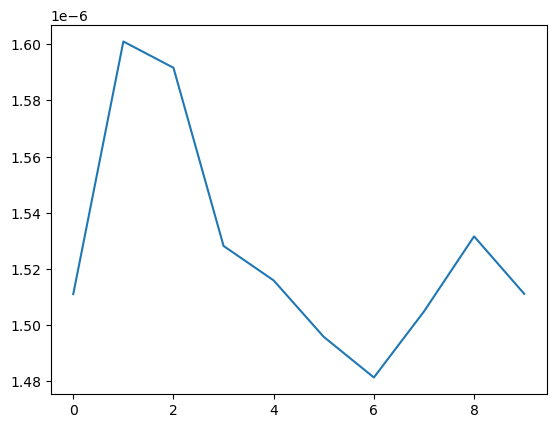

In [105]:
plt.plot(diffs)

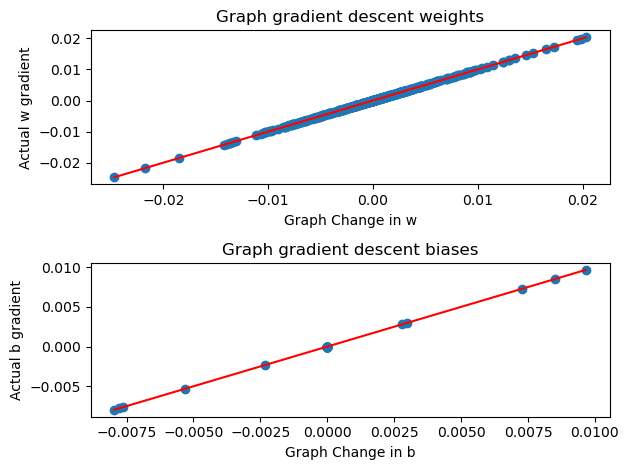

In [106]:
plt.subplot(2, 1, 1)

plt.title("Graph gradient descent weights")
plt.ylabel("Actual w gradient")
plt.xlabel("Graph Change in w")
plt.scatter(FFN_delta_w.detach().cpu(), delta_w.detach().cpu())

plt.plot([torch.min(FFN_delta_w.detach().cpu()), torch.max(FFN_delta_w.detach().cpu())], [torch.min(FFN_delta_w.detach().cpu()), torch.max(FFN_delta_w.detach().cpu())], c="red")

plt.subplot(2, 1, 2)

plt.title("Graph gradient descent biases")
plt.ylabel("Actual b gradient")
plt.xlabel("Graph Change in b")
plt.scatter(FFN_delta_b.detach().cpu(), delta_b.detach().cpu())

plt.plot([torch.min(FFN_delta_b.detach().cpu()), torch.max(FFN_delta_b.detach().cpu())], [torch.min(FFN_delta_b.detach().cpu()), torch.max(FFN_delta_b.detach().cpu())], c="red")

plt.tight_layout()

plt.show()

In [107]:
import tensorflow as tf
import cv2

In [142]:
SIZE = 28

(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x_train]).reshape(-1, SIZE**2)

x_train = torch.Tensor(x_train).to(device)
y_train = nn.functional.one_hot(torch.Tensor(y_train).to(device).long(), 10)

In [143]:
shape = [SIZE**2, 10]

connections = [(i, j) for k in range(len(shape)-1) for i in range(sum(shape[:k]), sum(shape[:k+1])) for j in range(sum(shape[:k+1]), sum(shape[:k+2]))]
print(len(connections))

graph = NeuralGraph(sum(shape), shape[0], shape[-1], connections, ch_n=ch_n, ch_e=ch_e, clamp_mode="none", value_init="zeros", aggregation="sum", use_label=True, device=device,
                     message_generator=Message, update_generator=Update, inp_int_generator=Inp_Enc, label_int_generator=Label_Enc, out_int_generator=Out_Dec)

7840


In [144]:
# graph.edges[..., 0] = torch.randn_like(graph.edges[..., 0])

In [145]:
print(x_train.shape, y_train.shape)

torch.Size([60000, 784]) torch.Size([60000, 10])


In [146]:
criterion = nn.MSELoss()

In [147]:
# Copy copycat vals to graph
def init_vals(copycat, batch_size=1):
    edge_states = []
    bias_states = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_states.append(layer.weight.clone().T.reshape(-1))
        bias_states.append(layer.bias.clone())

    edge_states = torch.cat(edge_states, axis=0)
    bias_states = torch.cat([torch.zeros(shape[0]).to(device), *bias_states], axis=0)

    graph.init_vals(batch_size=batch_size)
    graph.edges[:, :, 0] = edge_states.clone().unsqueeze(0)
    graph.nodes[:, :, 1] = bias_states

def get_grads(copycat):
    edge_grads = []
    bias_grads = []

    for layer in copycat.main[::2]:
        # split_bias = torch.repeat_interleave(layer.bias.clone().unsqueeze(-1), layer.weight.shape[1], axis=-1) / layer.weight.shape[1]
        
        edge_grads.append(layer.weight.grad.clone().T.reshape(-1))
        bias_grads.append(layer.bias.grad.clone())

    edge_grads = torch.cat(edge_grads, axis=0)
    bias_grads = torch.cat([torch.zeros(shape[0]).to(device), *bias_grads], axis=0)
    return edge_grads, bias_grads

In [149]:
copycat = Test_MLP(shape).to(device)
optimizer = torch.optim.SGD(copycat.parameters(), lr=lr)

init_vals(copycat)

old_w, old_b = get_states(copycat)

graph_old_w = graph.edges[..., 0].clone().flatten()
graph_old_b = graph.nodes[..., 1].clone().flatten()

graph_losses = []
ANN_losses = []
diffs = []

bar = tqdm(zip(x_train, y_train), total=len(x_train))
for x, y in bar:
    x = x.reshape(1, -1)
    y = 2*y.reshape(1, -1)-1

    optimizer.zero_grad()
    out = copycat(x)
    ANN_loss = torch.square(y - out).sum(-1).mean()
    ANN_loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = graph.forward(x, edges=True)
        graph.backward(x, y, edges=True)

        loss = torch.square(y - y_pred).sum(-1).mean()# criterion(y.flatten(), y_pred.flatten()) * 10
    
    graph_losses.append(loss.item())
    ANN_losses.append(ANN_loss.item())
    
    w, b = get_states(copycat)
    FFN_delta_w, FFN_delta_b = w - old_w, b - old_b
    # The negative lr has already been mult. so divide out
    delta_w = (graph.edges[..., 0].flatten() - graph_old_w.flatten())
    delta_b = (graph.nodes[..., 1].flatten() - graph_old_b.flatten())

    # Percent diff
    # print(torch.abs(delta_w).mean().item())
    diff = (torch.abs(FFN_delta_w - delta_w).mean() / torch.abs(FFN_delta_w).mean()).item()

    diffs.append(diff)

    bar.set_postfix({"graph_loss":loss.item(), "ANN_loss":ANN_loss.item(), "diff":diff})

  0%|          | 0/60000 [00:00<?, ?it/s]

KeyboardInterrupt: 

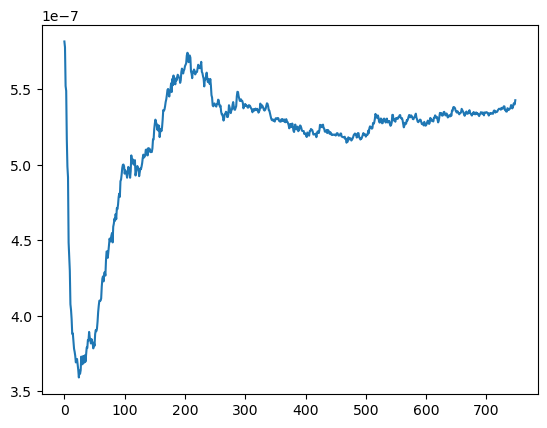

In [150]:
plt.plot(diffs)

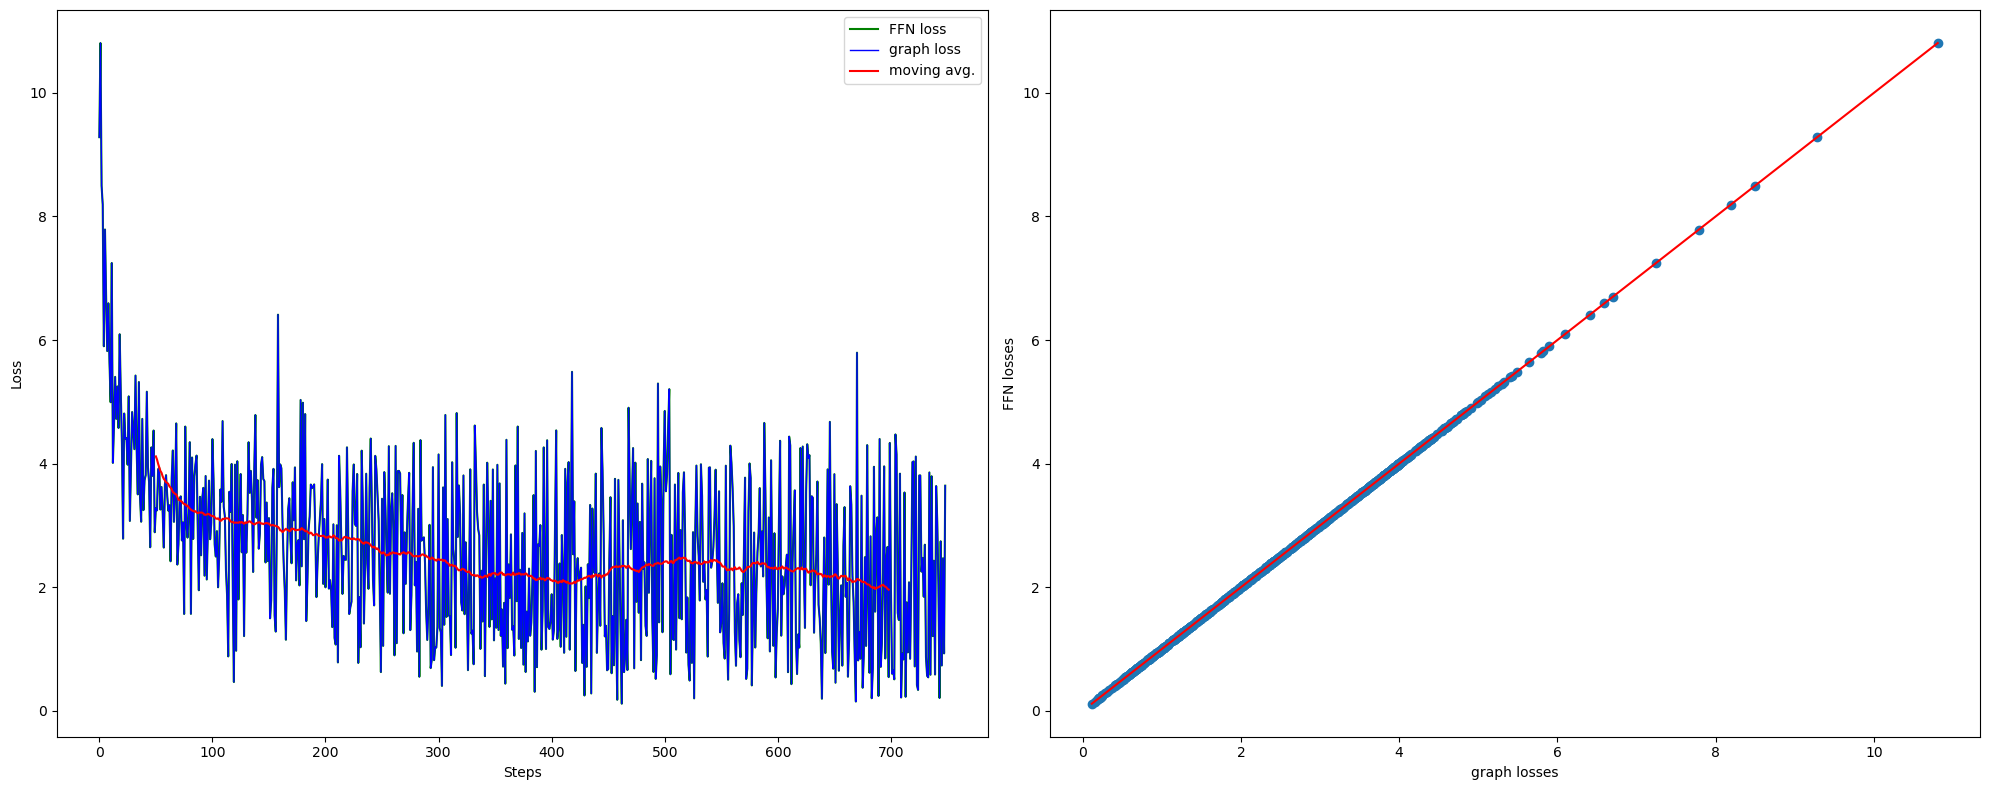

In [153]:
window = 100

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(ANN_losses, label="FFN loss", c="green")
plt.plot(graph_losses, label="graph loss", c="blue", linewidth=1)
plt.plot(np.arange(window/2, len(graph_losses)-window/2), [np.mean(graph_losses[i:i+window]) for i in range(len(graph_losses)-window)], label="moving avg.", c="red")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(graph_losses, ANN_losses)
plt.plot([np.min(graph_losses), np.max(graph_losses)], [np.min(graph_losses), np.max(graph_losses)], c="red")
plt.xlabel("graph losses")
plt.ylabel("FFN losses")

plt.tight_layout()
plt.show()
# plt.ylim(0, 1)
# plt.show()

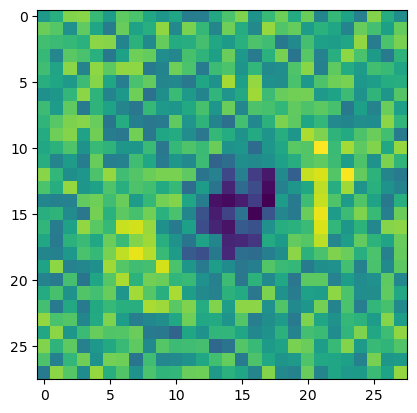

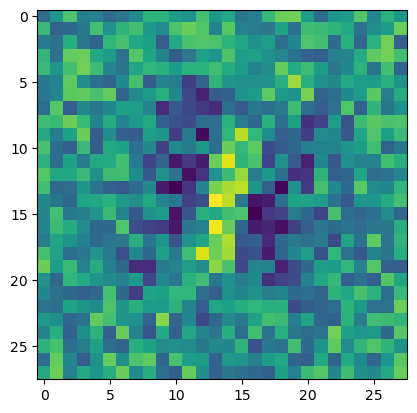

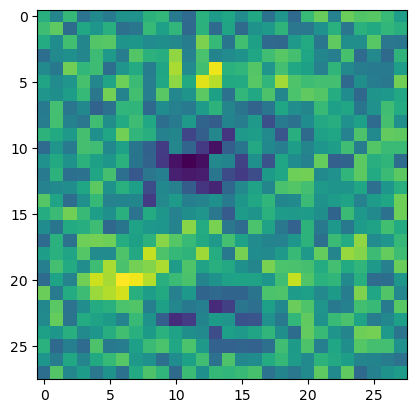

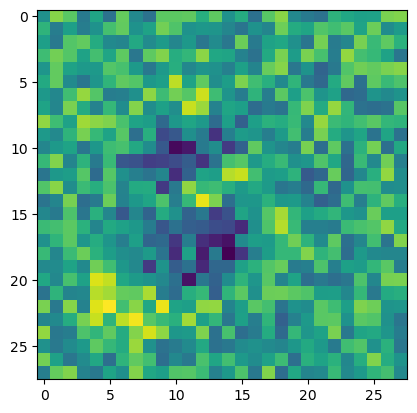

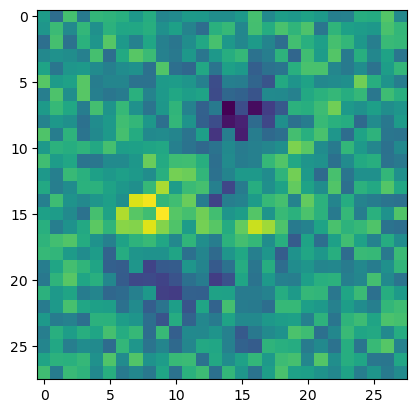

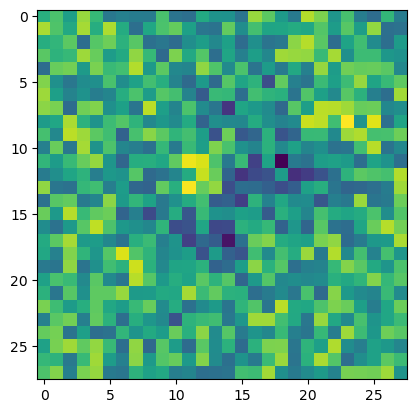

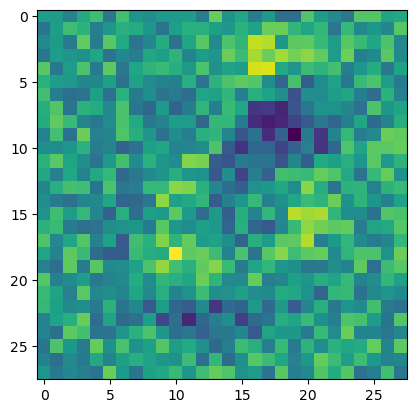

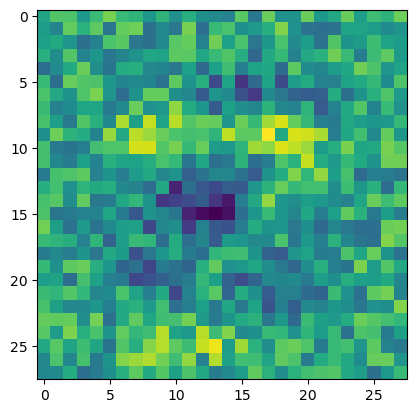

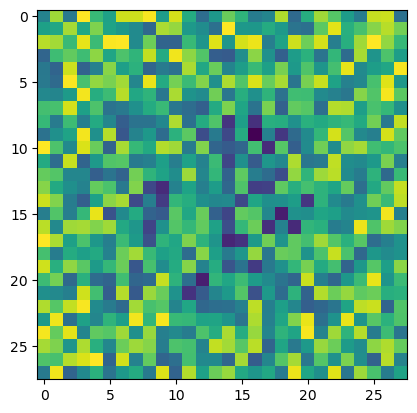

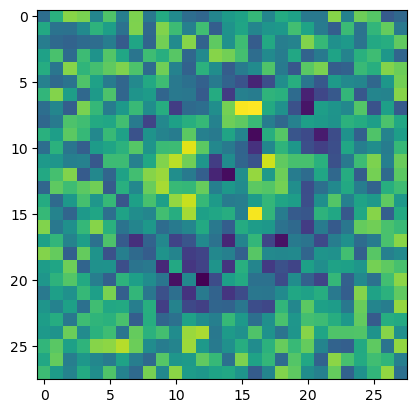

In [158]:
edges = graph.edges[0, :, 0].reshape(28, 28, 10)
for i in range(10):
    plt.imshow(edges[:, :, i].detach())
    plt.show()

# edges = graph.edges[0, :, 0].reshape(10, 28, 28)
# plt.imshow(edges[0, :, :].detach())
# plt.show()